In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

In [2]:
now = datetime.now()

before = now - relativedelta(years=10)

now_day = now.strftime("%Y-%m-%d")
before_day = before.strftime("%Y-%m-%d")
print(f"end : {now_day}")
print(f"start : {before_day}")

samsung_stock = pdr.get_data_yahoo("005930.KS", start=before, end=now_day)
print(samsung_stock)

end : 2022-09-20
start : 2012-09-20
[*********************100%***********************]  1 of 1 completed
               Open     High      Low    Close     Adj Close    Volume
Date                                                                  
2012-09-20  25860.0  26100.0  25680.0  25740.0  20736.685547  14199800
2012-09-21  26000.0  26140.0  25900.0  26040.0  20978.363281  14913400
2012-09-24  26000.0  26560.0  25840.0  26540.0  21381.183594  13195450
2012-09-25  26200.0  26680.0  26200.0  26540.0  21381.183594  11348000
2012-09-26  26260.0  26500.0  26120.0  26500.0  21348.953125  12054550
...             ...      ...      ...      ...           ...       ...
2022-09-13  57000.0  58500.0  56800.0  58100.0  58100.000000  17166581
2022-09-14  56200.0  57200.0  56100.0  56800.0  56800.000000  12524961
2022-09-15  57000.0  57100.0  56000.0  56000.0  56000.000000  11664819
2022-09-16  55600.0  56400.0  55500.0  56200.0  56200.000000  13456503
2022-09-19  56300.0  57000.0  56000.0  5640

In [3]:
close_prices = samsung_stock["Close"].values
print(close_prices)

window_size = 30

result_list = []
for i in range(len(close_prices) - (window_size + 1)):
    result_list.append(close_prices[i: i + (window_size+1)])
    
normal_data = []
for window in result_list:
    window_list = [((float(p) / float(window[0]))-1) for p in window]
    normal_data.append(window_list)

result_list = np.array(normal_data)
print(result_list.shape[0], result_list.shape[1])

[25740. 26040. 26540. ... 56000. 56200. 56400.]
2424 31


In [5]:
row = int(round(result_list.shape[0] * 0.9))
train = result_list[:row, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result_list[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result_list[row:, -1]

x_train.shape, x_test.shape

((2182, 30, 1), (242, 30, 1))

In [6]:
model = Sequential()
model.add(LSTM(window_size, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer="rmsprop")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 30)            3840      
                                                                 
 lstm_1 (LSTM)               (None, 64)                24320     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=50,
          epochs=50)

model.save(r"C:\파이썬과 40개의 작품들\39. 삼성전자의 주식 예측하기\samsung.h5")

Epoch 1/50
44/44 [==============================] - 1s 17ms/step - loss: 2.9127e-04 - val_loss: 1.7393e-04
Epoch 2/50
44/44 [==============================] - 1s 17ms/step - loss: 2.9127e-04 - val_loss: 2.3422e-04
Epoch 3/50
44/44 [==============================] - 1s 18ms/step - loss: 2.9275e-04 - val_loss: 1.7859e-04
Epoch 4/50
44/44 [==============================] - 1s 19ms/step - loss: 2.9313e-04 - val_loss: 2.1549e-04
Epoch 5/50
44/44 [==============================] - 1s 20ms/step - loss: 2.9502e-04 - val_loss: 1.7669e-04
Epoch 6/50
44/44 [==============================] - 1s 20ms/step - loss: 2.8674e-04 - val_loss: 1.7258e-04
Epoch 7/50
44/44 [==============================] - 1s 21ms/step - loss: 2.9343e-04 - val_loss: 1.7758e-04
Epoch 8/50
44/44 [==============================] - 1s 21ms/step - loss: 2.9311e-04 - val_loss: 1.8584e-04
Epoch 9/50
44/44 [==============================] - 1s 22ms/step - loss: 2.8969e-04 - val_loss: 1.7312e-04
Epoch 10/50
44/44 [==================

8/8 [==============================] - 0s 10ms/step


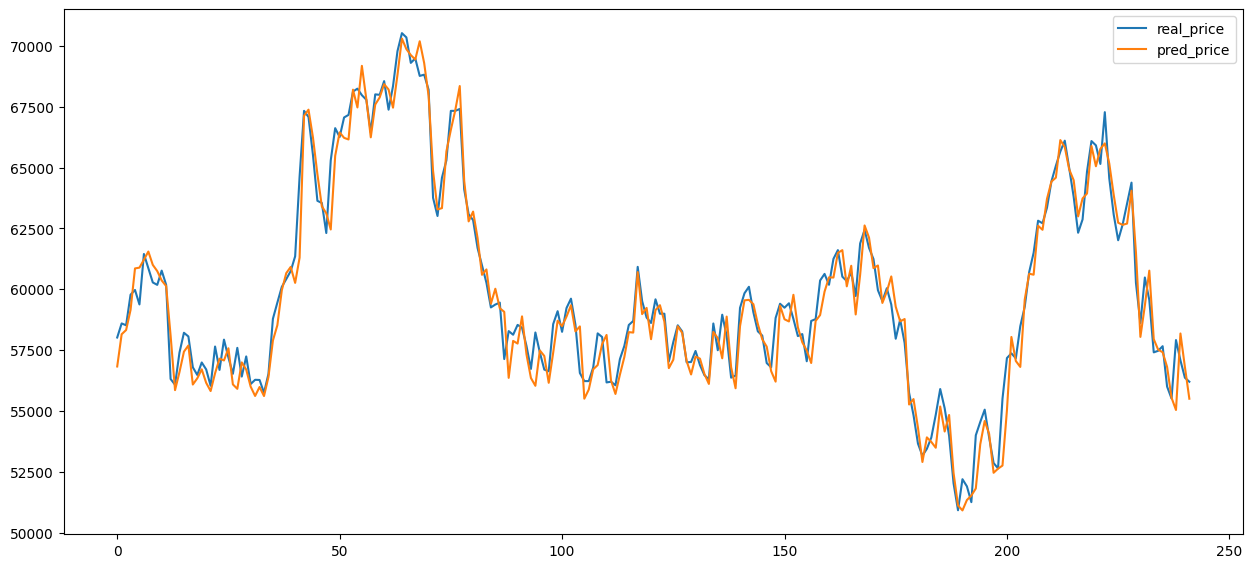

In [10]:
pred = model.predict(x_test)

pred_price = []
for i in pred :
    pred_price.append((i+1)*window[0])
    
real_price = []
for i in y_test :
    real_price.append((i+1)*window[0])
    
fig = plt.figure(facecolor="white", figsize=(70,15))
ax = fig.add_subplot(245)
ax.plot(real_price, label="real_price")
ax.plot(pred_price, label="pred_price")
ax.legend()
plt.show()